In [1]:
import numpy as np

from numpy import mean
from numpy import std

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import OneHotEncoder, KBinsDiscretizer, MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures, FunctionTransformer

from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, PoissonRegressor

from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_squared_log_error

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

np.random.seed(666)

### Get model evaluation metric

In [2]:
def mse (p,a):
    return mean_squared_error(a,p)

def rmse(a,p):  
    return np.sqrt(mean_squared_error(a,p))

def rmsle(a,p):
    return np.sqrt(mean_squared_log_error(a,p))

## Load & investigate the DFs, create the time stamp columns

In [3]:
train = pd.read_csv('train.csv', parse_dates=True)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

In [5]:
train.shape

(10886, 12)

In [6]:
train['datetime'] = pd.to_datetime(train['datetime'])
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [7]:
train.dtypes

datetime      datetime64[ns]
season                 int64
holiday                int64
workingday             int64
weather                int64
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
count                  int64
dtype: object

datetime - hourly date + timestamp

season -  1 = spring, 2 = summer, 3 = fall, 4 = winter

holiday - whether the day is considered a holiday

workingday - whether the day is neither a weekend nor holiday

weather 

          1: Clear, Few clouds, Partly cloudy, Partly cloudy
          
          2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
          
          3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
          
          4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 

temp - temperature in Celsius

atemp - "feels like" temperature in Celsius

humidity - relative humidity

windspeed - wind speed

casual - number of non-registered user rentals initiated

registered - number of registered user rentals initiated

count - number of total rentals

In [8]:
train['year'] = train['datetime'].dt.year
train['month'] = train['datetime'].dt.month
train['day']= train['datetime'].dt.day
train['hour'] = train['datetime'].dt.hour
train['weekday'] = train['datetime'].dt.dayofweek
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,year,month,day,hour,weekday
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,2011,1,1,0,5
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,2011,1,1,1,5
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2011,1,1,2,5
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,2011,1,1,3,5
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,2011,1,1,4,5


In [9]:
round(train.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
season,10886.0,2.51,1.12,1.00,2.00,3.00,4.00,4.00
holiday,10886.0,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,10886.0,0.68,0.47,0.00,0.00,1.00,1.00,1.00
weather,10886.0,1.42,0.63,1.00,1.00,1.00,2.00,4.00
temp,10886.0,20.23,7.79,0.82,13.94,20.50,26.24,41.00
atemp,10886.0,23.66,8.47,0.76,16.66,24.24,31.06,45.46
humidity,10886.0,61.89,19.25,0.00,47.00,62.00,77.00,100.00
windspeed,10886.0,12.80,8.16,0.00,7.00,13.00,17.00,57.00
casual,10886.0,36.02,49.96,0.00,4.00,17.00,49.00,367.00
registered,10886.0,155.55,151.04,0.00,36.00,118.00,222.00,886.00


In [10]:
test = pd.read_csv('test.csv', parse_dates=True)
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
test.shape

(6493, 9)

In [12]:
test['datetime'] = pd.to_datetime(test['datetime'])
test['year'] = test['datetime'].dt.year
test['month'] = test['datetime'].dt.month
test['day']= test['datetime'].dt.day
test['hour'] = test['datetime'].dt.hour
test['weekday'] = test['datetime'].dt.dayofweek
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour,weekday
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,2011,1,20,0,3
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,1,3
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,2011,1,20,2,3
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,3,3
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,2011,1,20,4,3


In [13]:
round(test.describe().T, 2)

,count,mean,std,min,25%,50%,75%,max
season,6493.0,2.49,1.09,1.00,2.00,3.00,3.00,4.00
holiday,6493.0,0.03,0.17,0.00,0.00,0.00,0.00,1.00
workingday,6493.0,0.69,0.46,0.00,0.00,1.00,1.00,1.00
weather,6493.0,1.44,0.65,1.00,1.00,1.00,2.00,4.00
temp,6493.0,20.62,8.06,0.82,13.94,21.32,27.06,40.18
atemp,6493.0,24.01,8.78,0.00,16.66,25.00,31.06,50.00
humidity,6493.0,64.13,19.29,16.00,49.00,65.00,81.00,100.00
windspeed,6493.0,12.63,8.25,0.00,7.00,11.00,17.00,56.00
year,6493.0,2011.50,0.50,2011.00,2011.00,2012.00,2012.00,2012.00
month,6493.0,6.57,3.43,1.00,4.00,7.00,10.00,12.00


#### No NaNs in either of the train, test DFs

## Some visual inspection

<AxesSubplot:>

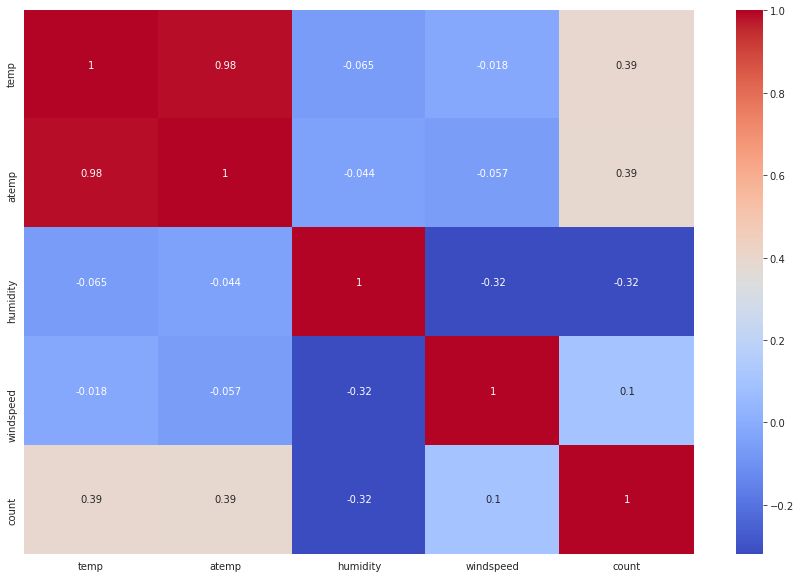

In [14]:
plt.figure(figsize=(15,10))
sns.heatmap(train[['temp','atemp','humidity','windspeed','count']].corr(), annot=True, cmap='coolwarm')

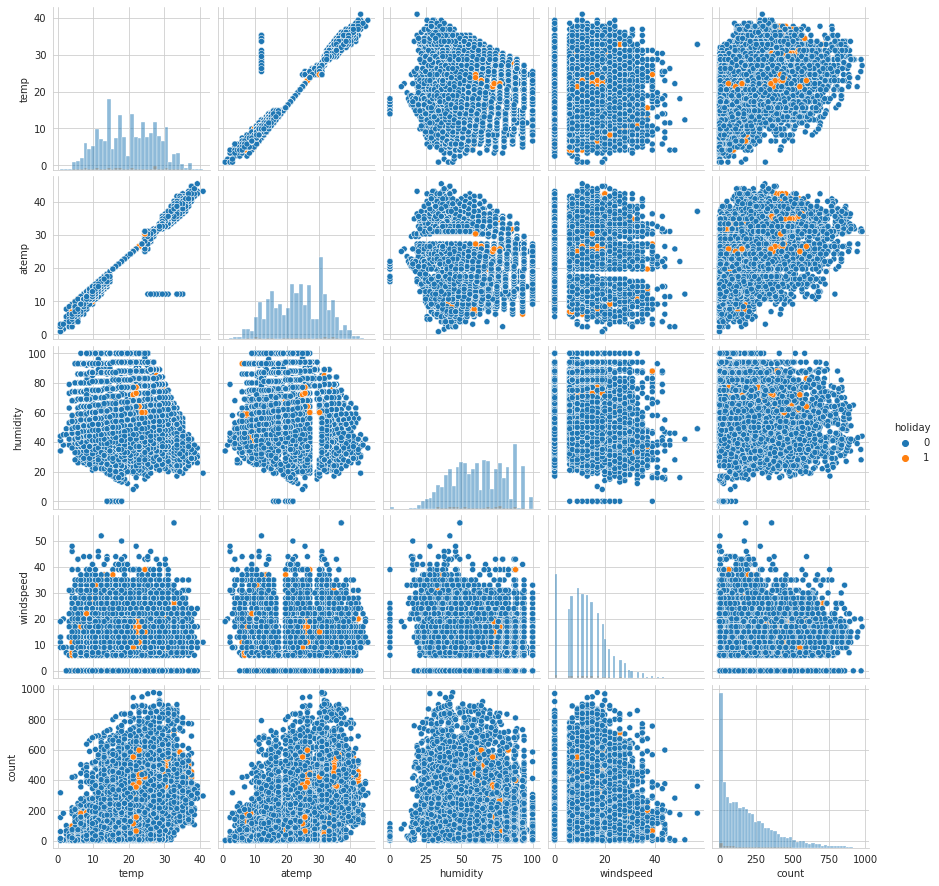

In [15]:
sns.pairplot(train[['holiday', 'temp','atemp','humidity','windspeed','count']], hue="holiday", diag_kind="hist");

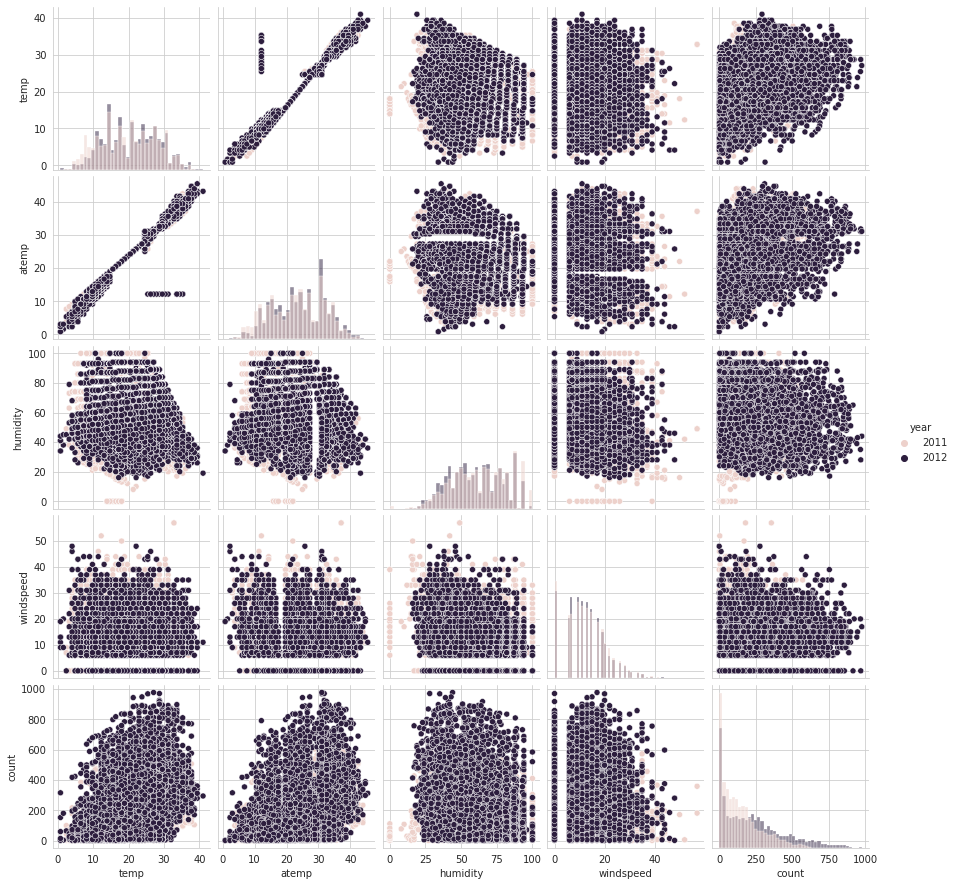

In [16]:
sns.pairplot(train[['year', 'temp','atemp','humidity','windspeed','count']], hue="year", diag_kind="hist");

<AxesSubplot:>

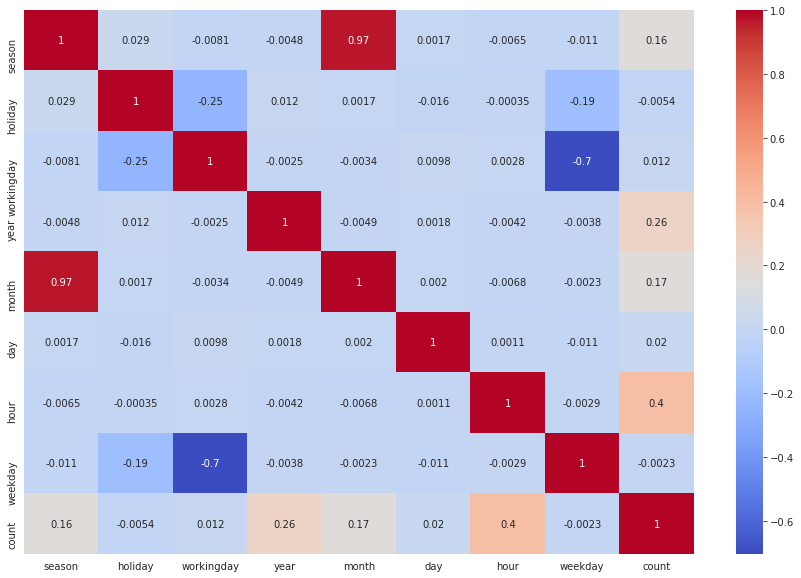

In [17]:
plt.figure(figsize=(15,10))
sns.heatmap(train[['season', 'holiday','workingday','year','month', 'day', 'hour', 'weekday', 'count']].corr(), annot=True, cmap='coolwarm')

### Start the train test split for train.csv & the pipeline

In [18]:
X = train.drop(columns=['datetime', 'temp', 'casual', 'registered', 'count', 'holiday', 'month', 'day', 'weekday'])
y = train['count']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=666, test_size=0.25)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8164, 8), (2722, 8), (8164,), (2722,))

In [19]:
# X_train.columns
# 'season', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'year'
cols_2b_scaled_int = ['season', 'workingday', 'weather', 'atemp', 'humidity', 'windspeed', 'year', 'hour']
cols_2b_scaled_int_pipeline = Pipeline([
    ('interactions', PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('normalize', MinMaxScaler())
])

In [20]:
feature_engineering = ColumnTransformer([
    ('normalize_all_cols', cols_2b_scaled_int_pipeline, cols_2b_scaled_int),
    ('interaction', cols_2b_scaled_int_pipeline, cols_2b_scaled_int)
])

In [21]:
feature_engineering.fit(X_train)

ColumnTransformer(transformers=[('normalize_all_cols',
                                 Pipeline(steps=[('interactions',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True)),
                                                 ('normalize',
                                                  MinMaxScaler())]),
                                 ['season', 'workingday', 'weather', 'atemp',
                                  'humidity', 'windspeed', 'year', 'hour']),
                                ('interaction',
                                 Pipeline(steps=[('interactions',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True)),
                                                 ('normalize',
                                                 

In [22]:
X_train_fe = feature_engineering.fit_transform(X_train)
X_train_fe
X_train_fe.shape

(8164, 72)

In [23]:
X_train_fe = pd.DataFrame(feature_engineering.fit_transform(X_train))
X_train_fe.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.000000,1.0,0.333333,0.569022,0.83,0.00000,1.0,1.000000,1.00,0.636364,...,0.714881,0.000000,0.569022,0.646368,0.000000,0.830000,0.830000,0.00000,0.000000,1.000000
1,0.000000,1.0,0.000000,0.189598,0.36,0.00000,0.0,0.434783,0.25,0.000000,...,0.109415,0.000000,0.189495,0.099168,0.000000,0.359821,0.156522,0.00000,0.000000,0.434567
2,0.333333,0.0,0.000000,0.586207,0.30,0.52639,0.0,0.739130,0.00,0.090909,...,0.265964,0.376003,0.585907,0.491752,0.236071,0.299851,0.221739,0.52639,0.497146,0.738763
3,1.000000,1.0,0.000000,0.603505,0.46,0.00000,1.0,0.478261,1.00,0.272727,...,0.419500,0.000000,0.603505,0.327313,0.000000,0.460000,0.220000,0.00000,0.000000,0.478261
4,0.333333,1.0,0.333333,0.517241,0.67,0.00000,0.0,0.260870,0.50,0.272727,...,0.526108,0.000000,0.516976,0.153726,0.000000,0.669667,0.174783,0.00000,0.000000,0.260740


### Proceed to modeling

In [24]:
random_forest_regressor = RandomForestRegressor(random_state=666, n_jobs=-1)
random_forest_regressor.fit(X_train_fe, y_train)
#round(random_forest_regressor.score(X_train_fe, y_train), 2) #
y_pred_rf_reg = random_forest_regressor.predict(X_train_fe)
rmsle(y_train, y_pred_rf_reg) # 

0.16869172304292812

In [25]:
elastic_net = ElasticNet(alpha=0.3, l1_ratio=0.2)
elastic_net.fit(X_train_fe, y_train)
#round(elastic_net.score(X_train_fe, y_train), 2) #
y_pred_en = elastic_net.predict(X_train_fe)
y_pred_en[y_pred_en < 0]=0.0
rmsle(y_train, y_pred_en) #

1.2566630404498844

In [26]:
poisson_regressor = PoissonRegressor(alpha=0.5, verbose=True, max_iter=1000)
poisson_regressor.fit(X_train_fe, y_train)
poisson_regressor_y_pred = poisson_regressor.predict(X_train_fe)
rmsle(y_train, poisson_regressor_y_pred) # 

1.1900300990171118

In [27]:
random_forest_parameter_grid = {'n_estimators': [100, 200],
                                'max_depth' : [10, 20],
                                'min_samples_split' : [500, 1000]}

In [28]:
gridsearch = GridSearchCV(random_forest_regressor, random_forest_parameter_grid, verbose=True, n_jobs=-1)
gridsearch.fit(X_train_fe, y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:   50.7s finished


GridSearchCV(estimator=RandomForestRegressor(n_jobs=-1, random_state=666),
             n_jobs=-1,
             param_grid={'max_depth': [10, 20],
                         'min_samples_split': [500, 1000],
                         'n_estimators': [100, 200]},
             verbose=True)

In [29]:
random_forest_best = gridsearch.best_estimator_
random_forest_best_y_predicted = random_forest_best.predict(X_train_fe)
rmsle(y_train, random_forest_best_y_predicted) #

0.6402626935303662

In [30]:
gradient_boosting = GradientBoostingRegressor(random_state=666)
gradient_boosting.fit(X_train_fe, y_train)
gradient_boosting_y_precited = gradient_boosting.predict(X_train_fe)
gradient_boosting_y_precited[gradient_boosting_y_precited<0]=0.0
rmsle(y_train, gradient_boosting_y_precited)

0.6039700710672461

In [31]:
gradient_boosting_hist = HistGradientBoostingRegressor(random_state=666)
gradient_boosting_hist.fit(X_train_fe, y_train)
gradient_boosting_hist_y_predicted = gradient_boosting_hist.predict(X_train_fe)
gradient_boosting_hist_y_predicted[gradient_boosting_hist_y_predicted<0]=0.0
rmsle(y_train, gradient_boosting_hist_y_predicted)

0.38906301115259706

In [32]:
xgb_reg = XGBRegressor(random_state=666)
xgb_reg.fit(X_train_fe, y_train)
xgb_reg_y_precited = xgb_reg.predict(X_train_fe)
xgb_reg_y_precited[xgb_reg_y_precited<0]=0.0
rmsle(y_train, xgb_reg_y_precited)

0.3374494364775103

In [33]:
lgbm_reg = LGBMRegressor(n_jobs=-1, random_state=666)
lgbm_reg.fit(X_train_fe, y_train)
lgbm_reg_y_pred = lgbm_reg.predict(X_train_fe)
lgbm_reg_y_pred[lgbm_reg_y_pred<0] = 0.0
rmsle(y_train, lgbm_reg_y_pred)

0.3848920894169938

In [34]:
cat_boost_reg = CatBoostRegressor(verbose=0, n_estimators=100, random_state=666)
cat_boost_reg.fit(X_train_fe, y_train)
cat_boost_reg_ypred = cat_boost_reg.predict(X_train_fe)
cat_boost_reg_ypred[cat_boost_reg_ypred<0] = 0.0
rmsle(y_train, cat_boost_reg_ypred)

0.5148721546559335

In [35]:
# feature_engineering.transform(X_test)

In [36]:
X_test_fe = pd.DataFrame(feature_engineering.transform(X_test))
X_test_fe.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.000000,1.0,0.333333,0.482759,0.94,0.000000,1.0,0.913043,0.25,0.090909,...,0.690506,0.000000,0.482759,0.503333,0.000000,0.940000,0.858261,0.000000,0.000000,0.913043
1,0.666667,1.0,0.333333,0.844884,0.66,0.333373,0.0,0.565217,0.75,0.454545,...,0.835918,0.340198,0.844456,0.537229,0.328917,0.659672,0.373043,0.333373,0.240769,0.564936
2,0.666667,1.0,0.000000,0.706953,0.65,0.157870,0.0,0.000000,0.75,0.181818,...,0.691549,0.135329,0.706593,0.000000,0.153400,0.649677,0.000000,0.157870,0.000000,0.000000
3,0.000000,0.0,0.333333,0.206897,0.47,0.157870,0.0,0.521739,0.00,0.090909,...,0.154790,0.041892,0.206785,0.128951,0.110920,0.469766,0.245217,0.157870,0.105247,0.521480
4,0.333333,1.0,0.666667,0.689655,0.57,0.491243,0.0,0.043478,0.50,0.454545,...,0.591951,0.411045,0.689304,0.033885,0.418585,0.569717,0.024783,0.491243,0.027291,0.043457


In [37]:
Xtest_random_forest_regressor_ypred_rf = random_forest_regressor.predict(X_test_fe)
round(rmsle(y_test, Xtest_random_forest_regressor_ypred_rf),3)

0.365

In [38]:
Xtest_random_forest_best_ypred = random_forest_best.predict(X_test_fe)
round(rmsle(y_test, Xtest_random_forest_best_ypred),3)

0.647

In [39]:
Xtest_gradient_boosting_ypred = gradient_boosting.predict(X_test_fe)
Xtest_gradient_boosting_ypred[Xtest_gradient_boosting_ypred < 0] = 0.0
round(rmsle(y_test, Xtest_gradient_boosting_ypred),3)

0.636

In [40]:
Xtest_gradient_boosting_h_ypred = gradient_boosting_hist.predict(X_test_fe)
Xtest_gradient_boosting_h_ypred[Xtest_gradient_boosting_h_ypred < 0] = 0.0
round(rmsle(y_test, Xtest_gradient_boosting_h_ypred),3)

0.43

In [41]:
Xtest_xgb_reg_y_precited = xgb_reg.predict(X_test_fe)
Xtest_xgb_reg_y_precited[Xtest_xgb_reg_y_precited<0]=0.0
round(rmsle(y_test, Xtest_xgb_reg_y_precited),3)

0.505

In [42]:
Xtest_lgbm_reg_y_precited = lgbm_reg.predict(X_test_fe)
Xtest_lgbm_reg_y_precited[Xtest_lgbm_reg_y_precited<0]=0.0
round(rmsle(y_test, Xtest_lgbm_reg_y_precited),3)

0.426

In [43]:
Xtest_cat_boost_reg_y_precited = cat_boost_reg.predict(X_test_fe)
Xtest_cat_boost_reg_y_precited[Xtest_cat_boost_reg_y_precited<0]=0.0
round(rmsle(y_test, Xtest_cat_boost_reg_y_precited),3)

0.538

In [44]:
test = test.drop(columns=['datetime', 'temp', 'holiday', 'month', 'day', 'weekday'])
test.head()

,season,workingday,weather,atemp,humidity,windspeed,year,hour
0,1,1,1,11.365,56,26.0027,2011,0
1,1,1,1,13.635,56,0.0000,2011,1
2,1,1,1,13.635,56,0.0000,2011,2
3,1,1,1,12.880,56,11.0014,2011,3
4,1,1,1,12.880,56,11.0014,2011,4


In [45]:
test_fe = pd.DataFrame(feature_engineering.transform(test))
test_fe.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,0.0,1.0,0.0,0.241379,0.56,0.456213,0.0,0.000000,0.25,0.0,...,0.212798,0.139678,0.241251,0.000000,0.381916,0.559722,0.000000,0.456213,0.000000,0.000000
1,0.0,1.0,0.0,0.293047,0.56,0.000000,0.0,0.043478,0.25,0.0,...,0.255301,0.000000,0.292892,0.014875,0.000000,0.559722,0.024348,0.000000,0.000000,0.043457
2,0.0,1.0,0.0,0.293047,0.56,0.000000,0.0,0.086957,0.25,0.0,...,0.255301,0.000000,0.292892,0.029750,0.000000,0.559722,0.048696,0.000000,0.000000,0.086913
3,0.0,1.0,0.0,0.275862,0.56,0.193018,0.0,0.130435,0.25,0.0,...,0.241165,0.066974,0.275716,0.042154,0.161584,0.559722,0.073043,0.193018,0.032170,0.130370
4,0.0,1.0,0.0,0.275862,0.56,0.193018,0.0,0.173913,0.25,0.0,...,0.241165,0.066974,0.275716,0.056206,0.161584,0.559722,0.097391,0.193018,0.042893,0.173827


In [46]:
test_fe.shape

(6493, 72)

In [47]:
predicted_rf_regressor = random_forest_regressor.predict(test_fe)
predicted_rf_regressor[predicted_rf_regressor<0]=0.0
predicted_rf_regressor.shape

(6493,)

In [48]:
predicted_lgb = lgbm_reg.predict(test_fe)
predicted_lgb[predicted_lgb<0]=0.0
predicted_lgb.shape

(6493,)

In [49]:
SS = pd.read_csv('sampleSubmission.csv')

output_skl_rf = pd.DataFrame({'datetime': SS.datetime, 'count': predicted_rf_regressor})
output_skl_rf.to_csv('my_submission_skl_rf.csv', index=False)

output_lgb = pd.DataFrame({'datetime': SS.datetime, 'count': predicted_lgb})
output_lgb.to_csv('my_submission_lgb.csv', index=False)

Kaggle scores are

sklearn random forest: .44

lightgbm: .49